In [64]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.activations import softmax, sigmoid
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout, PReLU, LeakyReLU, Input, BatchNormalization, Activation


In [65]:
# tf gpu 메모리 관련 코드 
gpus = tf.config.list_physical_devices(device_type = 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [66]:
# 출력 전부 보이기
# np.set_printoptions(threshold=sys.maxsize)
# gpu 설치 확인
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()
# gpu : 0, cpu : -1 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [67]:
with open('../data/pickle_complete/소형주_20221206_6개월_10개.pkl', 'rb') as f:
    stock_df = pickle.load(f) # 10개 대형주 df
with open('./pickle/pickle_corr_complete/소형주_20221206_6개월_10개_03.pkl', 'rb') as f:
    col_list = pickle.load(f) # 상관 계수에 따른 컬럼 리스트
len(col_list)

94

In [68]:
# col_list['날짜']
# col_list= col_list.drop('날짜')    # col_list 내에 날짜 컬럼이 있을 시만 제거

In [69]:
# 0.5까지 0, 0.6이상 부터 1 로 labeling
stock_df['pct_label'] = np.where(stock_df['pct_label'].values > 0.5 , 1, 0)
stock_df['pct_label'].value_counts()

1    262338
0    224961
Name: pct_label, dtype: int64

In [70]:
# label 원 핫 인코딩
ohe = OneHotEncoder(sparse=False)
y_stock_df = ohe.fit_transform(stock_df[['pct_label']])

# value 컬럼 설정
col_list = list(col_list.index) # col_list의 인덱스를 리스트로 생성
X_stock_df = stock_df.drop(['pct_label'],axis=1)
X_stock_df = X_stock_df.set_index(['날짜'])
X_stock_df = X_stock_df[col_list] # col_list에 있는 컬럼들만 사용

# values에 nan값이 있나 확인
print(list(X_stock_df.isnull().sum())) 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [71]:
# min_abs_scaler = MinMaxScaler()
min_abs_scaler = MaxAbsScaler()
X_stock_sc = min_abs_scaler.fit_transform(X_stock_df)

X_train, X_test, y_train, y_test = train_test_split(X_stock_sc, y_stock_df
                                                    , test_size=0.3, shuffle=True
                                                    , random_state=42, stratify=y_stock_df)

X_train = X_train.reshape(X_train.shape[0], X_stock_df.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_stock_df.shape[1], 1)
print('훈련 데이터의 크기 :', X_train.shape, y_train.shape)
print('테스트 데이터의 크기 :', X_test.shape, y_test.shape)

훈련 데이터의 크기 : (341109, 94, 1) (341109, 2)
테스트 데이터의 크기 : (146190, 94, 1) (146190, 2)


In [72]:
# from tensorflow import keras
# # 전이 학습할 모델 불러오기
# modelpath="./model/lstm_30_64_5_0.001_0.07_대형주_범위(0,1)_6개월.hdf5"
# transfer_model = keras.models.load_model(modelpath)
# transfer_model.trainable = False

# transfer_model.summary

In [73]:
# 모델 설정
inputs = Input(shape=(X_stock_df.shape[1],1))
lstm_out = LSTM(16, dropout=0.2,return_sequences=True)(inputs)
lstm_out = BatchNormalization()(lstm_out)
lstm_out = Activation('PReLU')(lstm_out)
lstm_out = LSTM(16, dropout=0.2)(lstm_out)
lstm_out = BatchNormalization()(lstm_out)
lstm_out = Activation('PReLU')(lstm_out)
lstm_out = Dense(2)(lstm_out)
lstm_out = BatchNormalization()(lstm_out)
lstm_out = Activation('softmax')(lstm_out) 

# stop지점 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=30)

# 모델 이름 설정
modelpath="./model/소형주_20221206_6개월_lstm_500ep_64bs_30pa_03newcor.hdf5"
# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

model = Model(inputs=inputs, outputs=lstm_out)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001, decay=1e-7), metrics=['accuracy'])

history=model.fit(X_train, y_train, epochs=500, batch_size=64,verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping_callback, checkpointer])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 94, 1)]           0         
                                                                 
 lstm_10 (LSTM)              (None, 94, 16)            1152      
                                                                 
 batch_normalization_15 (Bat  (None, 94, 16)           64        
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 94, 16)            1504      
                                                                 
 lstm_11 (LSTM)              (None, 16)                2112      
                                                                 
 batch_normalization_16 (Bat  (None, 16)               64        
 chNormalization)                                          

In [74]:
modelpath="./model/소형주_20221206_6개월_lstm_500ep_64bs_30pa_03newcor.hdf5"
model_pred = load_model(modelpath)
print("\n Test Accuracy: %.4f" % (model_pred.evaluate(X_test, y_test)[1]))



4569/4569 [==============================] - 30s 6ms/step - loss: 0.7368 - accuracy: 0.5384

 Test Accuracy: 0.5384


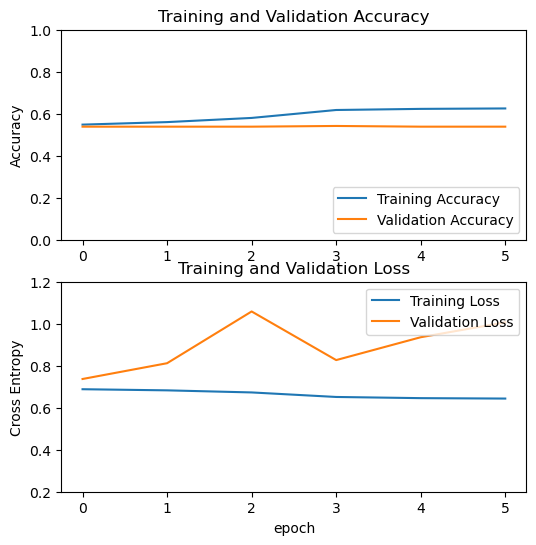

In [75]:
# #Plotting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0.2,1.2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [76]:
with open('./소형주_20221206_6개월_lstm_500ep_64bs_30pa_03newcor', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
# history = pickle.load(open('./소형주_20221206_6개월_lstm_500ep_64bs_30pa_03newcor', "rb"))